In [6]:
# Cell 1: Imports
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import deeptrack as dt
import deeplay as dl
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

In [7]:
# Cell 6: Data preparation
data_dir    = 'dataset'
batch_size  = 8
num_epochs  = 50
lr          = 1e-4
grid_rows   = 3
grid_cols   = 3
n_pieces    = grid_rows * grid_cols
crop_size   = 128
snr         = 0.1

In [8]:
# Cell 2: JigsawDataset with noise and grayscale
class JigsawDataset(Dataset):
    def __init__(self, root_dir, grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=None):
        self.files = sorted(os.listdir(root_dir))
        self.root = root_dir
        self.grid_rows = grid_rows
        self.grid_cols = grid_cols
        self.crop_size = crop_size
        self.snr = snr
        self.apply_noise = apply_noise
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.files[idx])).convert('RGB')
        img = img.resize((self.grid_cols*self.crop_size, self.grid_rows*self.crop_size))
        patches, labels = [], []
        for r in range(self.grid_rows):
            for c in range(self.grid_cols):
                left, top = c*self.crop_size, r*self.crop_size
                patch = img.crop((left, top, left+self.crop_size, top+self.crop_size))
                # Convert to grayscale
                patch = patch.convert('L')
                # Convert to numpy for DeepTrack
                patch_np = np.array(patch).astype(np.float32) / 255.0  # [0, 1] float32
                patch_np = patch_np[..., None]  # Add channel if needed
                
                if self.apply_noise:
                    noise = np.random.normal(0, self.snr, patch_np.shape)
                    patch_np = np.clip(patch_np + noise, 0, 1)


                

                # If you need to convert back to PIL for transforms:
                patch_uint8 = (patch_np.squeeze() * 255).astype(np.uint8)
                patch = Image.fromarray(patch_uint8, mode='L')
                if self.transform:
                    patch = self.transform(patch)
                patches.append(patch)
                labels.append(r*self.grid_cols + c)
        perm = np.random.permutation(len(patches))
        x = torch.stack([patches[i] for i in perm])
        y = torch.tensor([labels[i] for i in perm], dtype=torch.long)
        return x, y

In [9]:
# Improved data transform (replace your Cell 5)
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Improved model (replace your Cell 1: Improved Model Architecture)
import torch
import torch.nn as nn
from torchvision import models

class JigsawNet(nn.Module):
    def __init__(self, n_pieces, pretrained=True):
        """
        Jigsaw puzzle network based on ResNet-18 backbone.

        Args:
            n_pieces (int): number of pieces per side (e.g., 3 for 3x3 puzzle).
            pretrained (bool): whether to use ImageNet pretrained weights.
        """
        super().__init__()
        self.n_pieces = n_pieces

        # 1) Initialize ResNet-18 backbone
        #resnet = models.resnet18(pretrained=pretrained)
                
        if pretrained:
            weights = models.ResNet50_Weights.DEFAULT
        else:
            weights = None
        
        resnet = models.resnet50(weights=weights)
        # Replace first conv to accept single-channel input
        in_conv = resnet.conv1
        resnet.conv1 = nn.Conv2d(
            1,
            in_conv.out_channels,
            kernel_size=in_conv.kernel_size,
            stride=in_conv.stride,
            padding=in_conv.padding,
            bias=(in_conv.bias is not None)
        )

        # 2) Extract feature dimension before dropping the FC
        feat_dim = resnet.fc.in_features  # typically 512 for ResNet-18

        # 3) Build the convolutional trunk (drop classification head)
        self.backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            nn.Dropout2d(p=0.3),
            resnet.layer1, resnet.layer2,
            nn.Dropout2d(p=0.3),
            resnet.layer3, resnet.layer4,
            nn.AdaptiveAvgPool2d(1)
        )

        # 4) Build the MLP head that sees concatenated patch embeddings
        self.head = nn.Sequential(
            nn.Linear(n_pieces * feat_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, n_pieces * n_pieces)
        )

    def forward(self, x):
        """
        Forward pass.

        Args:
            x (torch.Tensor): input tensor of shape (B, N, C, H, W)
                where N = n_pieces * n_pieces.
        Returns:
            torch.Tensor: output logits of shape (B, n_pieces, n_pieces).
        """
        B, N, C, H, W = x.shape
        # Flatten batch of patches into batch dimension
        x = x.view(B * N, C, H, W)
        # Extract features per patch
        f = self.backbone(x)            # [B*N, feat_dim, 1, 1]
        f = f.view(B, N, -1)            # [B, N, feat_dim]
        # Concatenate features of all patches
        f = f.view(B, N * f.size(-1))   # [B, N*feat_dim]
        # Classify permutation
        logits = self.head(f)           # [B, n_pieces*n_pieces]
        return logits.view(B, self.n_pieces, self.n_pieces)


# Improved classifier with label smoothing (replace your Cell 4)
class JigsawClassifier(dl.Classifier):
    def compute_loss(self, y_hat, y):
        return nn.CrossEntropyLoss(label_smoothing=0.1)(y_hat.view(-1, self.model.n_pieces), y.view(-1))
    def metrics_preprocess(self, y_hat, y):
        return y_hat.view(-1, self.model.n_pieces), y.view(-1)

In [10]:
# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Validation/Test transforms (deterministic only)
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply different transforms to each dataset
train_dataset = JigsawDataset(os.path.join(data_dir, 'train'), grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=train_transform)
valid_dataset = JigsawDataset(os.path.join(data_dir, 'test'), grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=eval_transform)
test_dataset = JigsawDataset(os.path.join(data_dir, 'test'), grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=eval_transform)

In [11]:
train_loader = dl.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = dl.DataLoader(valid_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
test_loader = dl.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)

In [12]:
def visualize_jigsaw_sample(dataset, idx=1):
    """
    Visualize a single sample from the JigsawDataset in a square grid.

    Args:
        dataset: An instance of JigsawDataset
        idx: Index of the sample to visualize
    """
    import matplotlib.pyplot as plt
    import numpy as np

    x, y = dataset[idx]  # x: [n_pieces, 1, H, W], y: [n_pieces]
    n_pieces = x.shape[0]
    grid_cols = int(np.sqrt(n_pieces))
    grid_rows = int(np.ceil(n_pieces / grid_cols))

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(2*grid_cols, 2*grid_rows))
    axes = axes.flatten()

    for i in range(n_pieces):
        img = x[i].squeeze().numpy() * 0.5 + 0.5  # unnormalize if needed
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Orig pos: {y[i].item()}")
        axes[i].axis('off')

    # Hide any unused subplots
    for i in range(n_pieces, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f"Sample {idx} - Scrambled patches (grid view)")
    plt.tight_layout()
    plt.show()
    print("Original positions of patches (in scrambled order):", y.tolist())

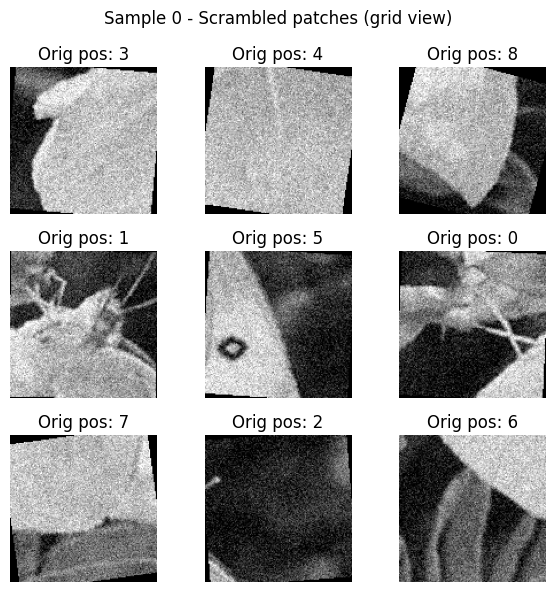

Original positions of patches (in scrambled order): [3, 4, 8, 1, 5, 0, 7, 2, 6]


In [13]:
visualize_jigsaw_sample(train_dataset, idx=0)

In [14]:

net = JigsawNet(n_pieces, pretrained=True)
classifier = JigsawClassifier(
    model=net,
    optimizer=torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-4),
    metrics=[Accuracy(task="multiclass", num_classes=n_pieces)]
)


trainer = dl.Trainer(max_epochs=num_epochs, accelerator='cuda', devices=1)
#trainer.fit(classifier, train_loader, val_loader)
torch.save(classifier.model, 'jigsaw_model_gray_noise.pth')
print("Model saved.")

Model saved.


In [15]:
results = trainer.test(classifier, test_loader)
print("Test results:", results)

c:\Users\alish\anaconda3\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 349/349 [01:23<00:00,  4.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testMulticlassAccuracy_epoch │     0.11083193868398666      │
│       test_loss_epoch        │      2.2713892459869385      │
└──────────────────────────────┴──────────────────────────────┘

Test results: [{'test_loss_epoch': 2.2713892459869385, 'testMulticlassAccuracy_epoch': 0.11083193868398666}]


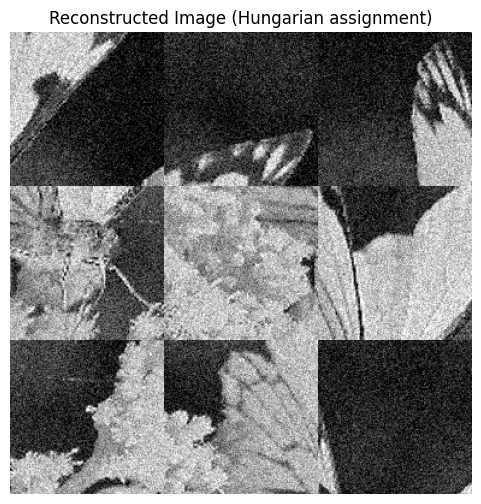

Original positions of patches (in scrambled order): [8, 0, 3, 1, 4, 7, 6, 2, 5]
Predicted positions for each patch (unique): [6, 2, 7, 8, 5, 3, 4, 1, 0]


In [16]:

from scipy.optimize import linear_sum_assignment

x_batch, y_batch = next(iter(val_loader))
x_batch = x_batch.to(classifier.device)
y_batch = y_batch.to(classifier.device)

with torch.no_grad():
    y_hat = classifier.model(x_batch)  # [batch, n_pieces, n_pieces]

# Use Hungarian algorithm for unique assignment
hungarian_preds = []
for i in range(y_hat.shape[0]):
    cost_matrix = -y_hat[i].cpu().numpy()  # maximize logits = minimize negative logits
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    # col_ind gives the predicted position for each patch (unique)
    hungarian_preds.append(col_ind)
hungarian_preds = np.stack(hungarian_preds)  # [batch, n_pieces]

# Reconstruct the image for the first sample in the batch
reconstructed = np.zeros((grid_rows * crop_size, grid_cols * crop_size))
for idx in range(n_pieces):
    pred_pos = hungarian_preds[0, idx]
    row, col = divmod(pred_pos, grid_cols)
    img_patch = x_batch[0, idx].cpu().squeeze().numpy() * 0.5 + 0.5  # unnormalize
    reconstructed[row * crop_size:(row + 1) * crop_size, col * crop_size:(col + 1) * crop_size] = img_patch

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap='gray')
plt.title("Reconstructed Image (Hungarian assignment)")
plt.axis('off')
plt.show()
print("Original positions of patches (in scrambled order):", y_batch[0].tolist())
print("Predicted positions for each patch (unique):", hungarian_preds[0].tolist())

In [22]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

def reconstruct_and_save_with_dataset(model_path, test_image_path, output_path="reconstructed.png", 
                                      grid_rows=3, grid_cols=3, crop_size=128, snr=0.1, transform=None):
    """
    Reconstructs a jigsaw image using a trained model and the JigsawDataset logic, then saves the result.
    Also plots the original source image next to the reconstructed output.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_pieces = grid_rows * grid_cols

    # Use the same transform as in training if not provided
    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    # Create a temporary dataset with just the test image
    class SingleImageJigsawDataset(JigsawDataset):
        def __init__(self, image_path, grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=None):
            self.files = [os.path.basename(image_path)]
            self.root = os.path.dirname(image_path)
            self.grid_rows = grid_rows
            self.grid_cols = grid_cols
            self.crop_size = crop_size
            self.snr = snr
            self.apply_noise = apply_noise
            self.transform = transform

    dataset = SingleImageJigsawDataset(
        test_image_path, grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=transform
    )
    x, y = dataset[0]  # x: [n_pieces, 1, H, W], y: [n_pieces]

    # Feed to model
    model = torch.load(model_path, map_location=device)
    model.eval()
    model.to(device)
    
    x = x.unsqueeze(0).to(device)  # [1, n_pieces, 1, H, W]
    with torch.no_grad():
        y_hat = model(x)  # [1, n_pieces, n_pieces]
        # Use Hungarian algorithm for unique assignment
        cost_matrix = -y_hat[0].cpu().numpy()  # maximize logits = minimize negative logits
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        preds = col_ind  # [n_pieces], unique assignment

    print("original positions (in shuffled order):", y.tolist())
    print("Predicted positions (Hungarian):", preds.tolist())
    # Reconstruct image based on model prediction
    reconstructed = np.zeros((grid_rows * crop_size, grid_cols * crop_size))
    for idx in range(n_pieces):
        pred_pos = preds[idx]
        row, col = divmod(pred_pos, grid_cols)
        img_patch = x[0, idx].cpu().squeeze().numpy() * 0.5 + 0.5  # unnormalize
        reconstructed[row * crop_size:(row + 1) * crop_size, col * crop_size:(col + 1) * crop_size] = img_patch

    reconstructed_img = Image.fromarray((reconstructed * 255).astype(np.uint8), mode='L')
    reconstructed_img.save(output_path)
    print(f"Reconstructed image saved to {output_path}")
    scrambled = np.zeros((grid_rows * crop_size, grid_cols * crop_size))
    for idx in range(n_pieces):
        row, col = divmod(idx, grid_cols)
        img_patch = x[0, idx].cpu().squeeze().numpy() * 0.5 + 0.5  # unnormalize
        scrambled[row * crop_size:(row + 1) * crop_size, col * crop_size:(col + 1) * crop_size] = img_patch

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(scrambled, cmap='gray')
    axs[0].set_title("Shuffled Input")
    axs[0].axis('off')
    axs[1].imshow(reconstructed, cmap='gray')
    axs[1].set_title("Model Reconstructed")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()
    # Plot the original source image (not resized, not grayscaled) and reconstructed output side by side
    # source_img = Image.open(test_image_path)
    # fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # axs[0].imshow(source_img)
    # axs[0].set_title("Source Image")
    # axs[0].axis('off')
    # axs[1].imshow(reconstructed, cmap='gray')
    # axs[1].set_title("Model Reconstructed")
    # axs[1].axis('off')
    # plt.tight_layout()
    # plt.show()

C:\Users\alish\AppData\Local\Temp\ipykernel_27404\3587217957.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


original positions (in shuffled order): [5, 0, 3, 7, 1, 4, 8, 6, 2]
Predicted positions (Hungarian): [5, 0, 3, 7, 1, 4, 8, 6, 2]
Reconstructed image saved to reconstructed.png


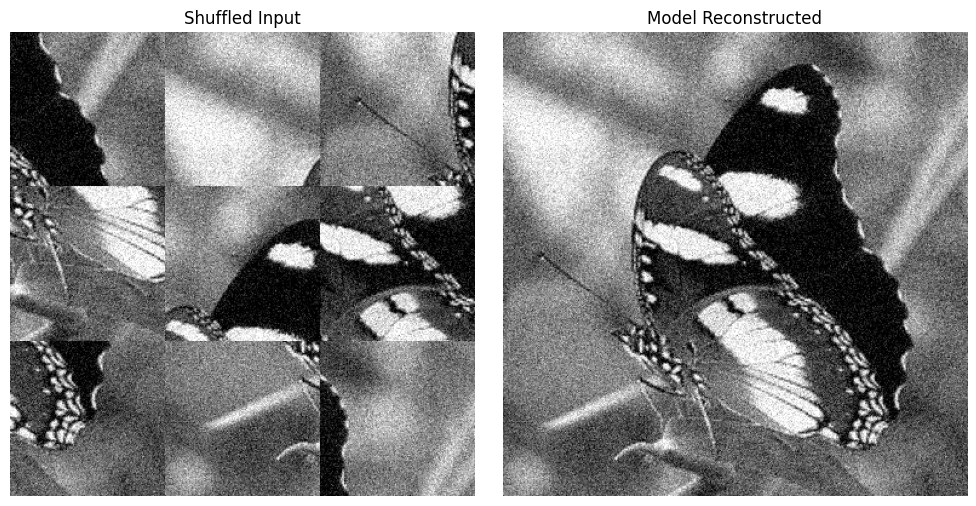

In [27]:
reconstruct_and_save_with_dataset('models\jigsaw_model.pth', 'dataset/test\Image_1313.jpg', output_path='reconstructed.png', grid_rows=3, grid_cols=3, crop_size=128)

In [19]:
def reconstruct_and_save_with_dataset(
    model_path, 
    test_folder, 
    result_folder="jigsaw_results", 
    grid_rows=3, 
    grid_cols=3, 
    crop_size=128, 
    snr=0.1, 
    transform=None
):
    """
    Reconstructs all images in test_folder using a trained model and saves results in result_folder.
    Scrambled and reconstructed images are saved in separate subfolders.
    """
    import os
    import torch
    from torchvision import transforms
    from PIL import Image
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    scrambled_dir = os.path.join(result_folder, "scrambled")
    reconstructed_dir = os.path.join(result_folder, "reconstructed")
    os.makedirs(scrambled_dir, exist_ok=True)
    os.makedirs(reconstructed_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_pieces = grid_rows * grid_cols

    if transform is None:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    class SingleImageJigsawDataset(JigsawDataset):
        def __init__(self, image_path, grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=None):
            self.files = [os.path.basename(image_path)]
            self.root = os.path.dirname(image_path)
            self.grid_rows = grid_rows
            self.grid_cols = grid_cols
            self.crop_size = crop_size
            self.snr = snr
            self.apply_noise = apply_noise
            self.transform = transform

    model = torch.load(model_path, map_location=device)
    model.eval()
    model.to(device)

    image_files = [f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img_name in image_files:
        img_path = os.path.join(test_folder, img_name)
        dataset = SingleImageJigsawDataset(
            img_path, grid_rows, grid_cols, crop_size, snr=snr, apply_noise=True, transform=transform
        )
        x, y = dataset[0]  # x: [n_pieces, 1, H, W], y: [n_pieces]

        # --- Save the scrambled jigsaw input image ---
        patches = []
        for i in range(n_pieces):
            patch = x[i].cpu().squeeze().numpy() * 0.5 + 0.5  # unnormalize
            patch = np.clip(patch, 0, 1)
            patch_uint8 = (patch * 255).astype(np.uint8)
            patches.append(patch_uint8)
        scrambled = np.zeros((grid_rows * crop_size, grid_cols * crop_size), dtype=np.uint8)
        for idx in range(n_pieces):
            row, col = divmod(idx, grid_cols)
            scrambled[row * crop_size:(row + 1) * crop_size, col * crop_size:(col + 1) * crop_size] = patches[idx]
        scrambled_path = os.path.join(scrambled_dir, f"{os.path.splitext(img_name)[0]}_scrambled.png")
        Image.fromarray(scrambled, mode='L').save(scrambled_path)

        # --- Model prediction and reconstruction ---
        x_input = x.unsqueeze(0).to(device)  # [1, n_pieces, 1, H, W]
        with torch.no_grad():
            y_hat = model(x_input)  # [1, n_pieces, n_pieces]
            cost_matrix = -y_hat[0].cpu().numpy()
            _, col_ind = linear_sum_assignment(cost_matrix)
            preds = col_ind

        reconstructed = np.zeros((grid_rows * crop_size, grid_cols * crop_size))
        for idx in range(n_pieces):
            pred_pos = preds[idx]
            row, col = divmod(pred_pos, grid_cols)
            img_patch = x[idx].cpu().squeeze().numpy() * 0.5 + 0.5
            reconstructed[row * crop_size:(row + 1) * crop_size, col * crop_size:(col + 1) * crop_size] = img_patch

        reconstructed_img = Image.fromarray((reconstructed * 255).astype(np.uint8), mode='L')
        reconstructed_path = os.path.join(reconstructed_dir, f"{os.path.splitext(img_name)[0]}_reconstructed.png")
        reconstructed_img.save(reconstructed_path)

        print(f"Processed {img_name}: scrambled saved to {scrambled_path}, reconstructed saved to {reconstructed_path}")

In [ ]:
# reconstruct_and_save_with_dataset(
#     model_path='models\jigsaw_model.pth',
#     test_folder='dataset/test',
#     result_folder='results//jigsaw',
#     grid_rows=3,
#     grid_cols=3,
#     crop_size=128
)

C:\Users\alish\AppData\Local\Temp\ipykernel_27404\2479282993.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Processed Image_1.jpg: scrambled saved to results//jigsaw\scrambled\Image_1_scrambled.png, reconstructed saved to results//jigsaw\reconstructed\Image_1_reconstructed.png
Processed Image_10.jpg: scrambled saved to results//jigsaw\scrambled\Image_10_scrambled.png, reconstructed saved to results//jigsaw\reconstructed\Image_10_reconstructed.png
Processed Image_100.jpg: scrambled saved to results//jigsaw\scrambled\Image_100_scrambled.png, reconstructed saved to results//jigsaw\reconstructed\Image_100_reconstructed.png
Processed Image_1000.jpg: scrambled saved to results//jigsaw\scrambled\Image_1000_scrambled.png, reconstructed saved to results//jigsaw\reconstructed\Image_1000_reconstructed.png
Processed Image_1001.jpg: scrambled saved to results//jigsaw\scrambled\Image_1001_scrambled.png, reconstructed saved to results//jigsaw\reconstructed\Image_1001_reconstructed.png
Processed Image_1002.jpg: scrambled saved to results//jigsaw\scrambled\Image_1002_scrambled.png, reconstructed saved to res

KeyboardInterrupt: 